In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import sys
import pdb

In [3]:
sys.path.append('../..')

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from os import listdir
from os.path import isfile, join
from tqdm import tqdm

from sklearn.model_selection import KFold

from utils import calc_loadings
from loaders import load_sabes 
from decoders import lr_decoder, lr_encoder

In [6]:
dimreduc_df = pd.read_pickle("./sabes_dimreduc_df.dat")
data_files = dimreduc_df["data_file"].unique()

In [7]:
data_path = '/media/akumar/Secondary/data/sabes'

In [8]:
dimreduc_df.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'data_file',
       'loader_args', 'T', 'dimreduc', 'coef', 'score'],
      dtype='object')

### Decoding/Encoding

In [9]:
decoder_params = {'trainlag': 4, 'testlag': 4, 'decoding_window': 3}
fold_idx = 0

result = {}
for data_file in tqdm(data_files):
    
    result[data_file] = {}
    
    dca_df = dimreduc_df.loc[(dimreduc_df['data_file'] == data_file) & \
                                (dimreduc_df['dimreduc'] == "DCA") & \
                                (dimreduc_df['fold_idx'] == fold_idx)]
    pca_df = dimreduc_df.loc[(dimreduc_df['data_file'] == data_file) & \
                             (dimreduc_df['dimreduc'] == "PCA") & \
                             (dimreduc_df['fold_idx'] == fold_idx)]
    
    dat = load_sabes('%s/%s' % (data_path, data_file), **dca_df.iloc[0]["loader_args"])
    
    X = np.squeeze(dat['spike_rates'])
    Z = dat['behavior']
    kfold = KFold(n_splits=5, shuffle=False)
    next(kfold.split(X))
    train_idxs, test_idxs = next(kfold.split(X))
    ztrain = Z[train_idxs, :]
    ztest = Z[test_idxs, :]

    # Population level decoding/encoding - use the coefficient in the linear fit
    # Record both the weights in the coefficient but also the loadings onto the SVD

    xtrain = X[train_idxs, :]
    xtest = X[test_idxs, :]
    
    _, _, _, decodingregressor = lr_decoder(xtest, xtrain, ztest, ztrain, **decoder_params)
    _, encodingregressor = lr_encoder(xtest, xtrain, ztest, ztrain, **decoder_params)

    result[data_file]['decoding_weights'] = decodingregressor.coef_
    result[data_file]['encoding_weights'] = encodingregressor.coef_
    
    u1, s1, vh1 = np.linalg.svd(decodingregressor.coef_[0:2, :], full_matrices=False)
    u2, s2, vh2 = np.linalg.svd(decodingregressor.coef_[2:4, :], full_matrices=False)
    u3, s3, vh3 = np.linalg.svd(decodingregressor.coef_[4:6, :], full_matrices=False)

    
    u4, s4, vh4 = np.linalg.svd(encodingregressor.coef_, full_matrices=False)
    
    result[data_file]['decoding_pos_svd'] = vh1
    result[data_file]['decoding_vel_svd'] = vh2
    result[data_file]['decoding_acc_svd'] = vh3

    result[data_file]['encoding_svd'] = u4
    
    r2_pos_decoding, r2_vel_decoding, r2_encoding = [], [], []
    
    decoding_weights = []
    encoding_weights = []
    
    decoding_weights_svd = []
    encoding_weights_svd = []
    
    
    for neu_idx in range(X.shape[1]):           #Fit all neurons one by one
        
        xtrain = X[train_idxs, neu_idx][:, np.newaxis]
        xtest = X[test_idxs, neu_idx][:, np.newaxis]
        # Decoding
        r2_pos, r2_vel, _, dr = lr_decoder(xtest, xtrain, ztest, ztrain, **decoder_params)
        r2_pos_decoding.append(r2_pos)
        r2_vel_decoding.append(r2_vel)
        
        decoding_weights.append(dr.coef_)
        
        # Encoding
        r2_encoding_, er = lr_encoder(xtest, xtrain, ztest, ztrain, **decoder_params)
        r2_encoding.append(r2_encoding_)
        encoding_weights.append(er.coef_)        
        
    result[data_file]['su_r2_pos_decoding'] = r2_pos_decoding
    result[data_file]['su_r2_vel_decoding'] = r2_vel_decoding
    result[data_file]['su_r2_encoding'] = r2_encoding
    result[data_file]['su_decoding_weight'] = decoding_weights
    result[data_file]['su_encoding_weight'] = encoding_weights        
    
    dim_vals = np.unique(dca_df['dim'].values)
    dca_loadings = np.zeros((dim_vals.size, X.shape[1]))
    pca_loadings = np.zeros((dim_vals.size, X.shape[1]))
    
    for i, dim_ in enumerate(dim_vals):
        dca_df_ = dca_df.loc[dca_df['dim'] == dim_]
        dca_loadings[i, :] = calc_loadings(dca_df_.iloc[0]['coef'])
        pca_loadings[i, :] = calc_loadings(pca_df.iloc[0]['coef'][:, 0:dim_])
    
    result[data_file]['dca_loadings'] = dca_loadings
    result[data_file]['pca_loadings'] = pca_loadings

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [04:08<00:00,  8.86s/it]


In [10]:
import pickle

In [37]:
# with open('loadings_v_r2.dat', 'wb') as f:
#     f.write(pickle.dumps(result))

In [13]:
with open('loadings_v_r2.dat', 'rb') as f:
    result = pickle.load(f)

In [11]:
dim_vals = np.arange(20)

In [12]:
# For each quantity, calculate the spearman r2 
dca_decoding_weightsr2 = np.zeros(dim_vals.size)
dca_decoding_svdr2 = np.zeros(dim_vals.size)
pca_decoding_weightsr2 = np.zeros(dim_vals.size)
pca_decoding_svdr2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_dca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for data_file in data_files:
        y_dca.extend(result[data_file]['dca_loadings'][i, :])
        y_pca.extend(result[data_file]['pca_loadings'][i, :])
        
        x1.extend(calc_loadings(result[data_file]['decoding_weights'][2:4, :].T, 3))
        x2.extend(calc_loadings(result[data_file]['decoding_vel_svd'].T, 3))

    dca_decoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_dca)[0]
    dca_decoding_svdr2[i] = scipy.stats.spearmanr(x2, y_dca)[0]
    
    pca_decoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_pca)[0]
    pca_decoding_svdr2[i] = scipy.stats.spearmanr(x2, y_pca)[0]

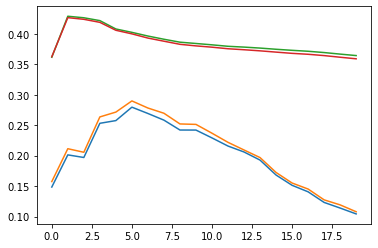

In [13]:
plt.plot(dca_decoding_weightsr2)
plt.plot(dca_decoding_svdr2)
plt.plot(pca_decoding_weightsr2)
plt.plot(pca_decoding_svdr2)

In [14]:
result[data_file]['encoding_weights'].shape

(137, 6)

In [15]:
# For each quantity, calculate the spearman r2 
dca_encoding_weightsr2 = np.zeros(dim_vals.size)
dca_encoding_svdr2 = np.zeros(dim_vals.size)
pca_encoding_weightsr2 = np.zeros(dim_vals.size)
pca_encoding_svdr2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_dca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for data_file in data_files:
        y_dca.extend(result[data_file]['dca_loadings'][i, :])
        y_pca.extend(result[data_file]['pca_loadings'][i, :])
        
        x1.extend(calc_loadings(result[data_file]['encoding_weights'], 1))
        x2.extend(calc_loadings(result[data_file]['encoding_svd'], 1))

    dca_encoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_dca)[0]
    dca_encoding_svdr2[i] = scipy.stats.spearmanr(x2, y_dca)[0]
    
    pca_encoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_pca)[0]
    pca_encoding_svdr2[i] = scipy.stats.spearmanr(x2, y_pca)[0]

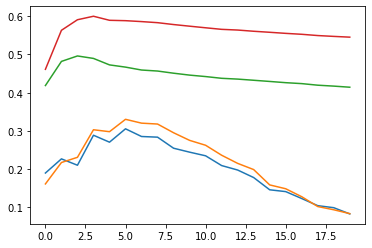

In [16]:
plt.plot(dca_encoding_weightsr2)
plt.plot(dca_encoding_svdr2)
plt.plot(pca_encoding_weightsr2)
plt.plot(pca_encoding_svdr2)

In [17]:
result[data_file]['su_decoding_weight'][0].shape

(6, 3)

In [18]:
# For each quantity, calculate the spearman r2 
dca_suposweight_r2 = np.zeros(dim_vals.size)
dca_suvelweight_r2 = np.zeros(dim_vals.size)
pca_suposweight_r2 = np.zeros(dim_vals.size)
pca_suvelweight_r2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_dca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for data_file in data_files:
        y_dca.extend(result[data_file]['dca_loadings'][i, :])
        y_pca.extend(result[data_file]['pca_loadings'][i, :])
        
        x1.extend([np.linalg.norm(result[data_file]['su_decoding_weight'][idx][0:2, :])
                   for idx in range(len(result[data_file]['su_decoding_weight']))])
        x2.extend([np.linalg.norm(result[data_file]['su_decoding_weight'][idx][2:4, :])
                   for idx in range(len(result[data_file]['su_decoding_weight']))])

    dca_suposweight_r2[i] = scipy.stats.spearmanr(x1, y_dca)[0]
    dca_suvelweight_r2[i] = scipy.stats.spearmanr(x2, y_dca)[0]
    
    pca_suposweight_r2[i] = scipy.stats.spearmanr(x1, y_pca)[0]
    pca_suvelweight_r2[i] = scipy.stats.spearmanr(x2, y_pca)[0]

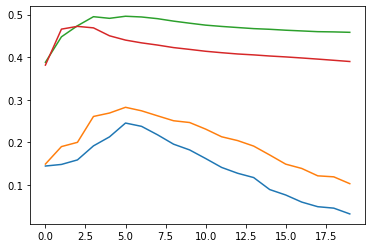

In [19]:
plt.plot(dca_suposweight_r2)
plt.plot(dca_suvelweight_r2)
plt.plot(pca_suposweight_r2)
plt.plot(pca_suvelweight_r2)

In [20]:
result[data_file]['su_encoding_weight'][0].shape

(1, 6)

In [21]:
# For each quantity, calculate the spearman r2 
dca_suencoding_r2 = np.zeros(dim_vals.size)
pca_suencoding_r2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_dca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for data_file in data_files:
        y_dca.extend(result[data_file]['dca_loadings'][i, :])
        y_pca.extend(result[data_file]['pca_loadings'][i, :])
        
        x1.extend([np.linalg.norm(result[data_file]['su_encoding_weight'][idx])
                   for idx in range(len(result[data_file]['su_encoding_weight']))])

    dca_suencoding_r2[i] = scipy.stats.spearmanr(x1, y_dca)[0]
    pca_suencoding_r2[i] = scipy.stats.spearmanr(x1, y_pca)[0]

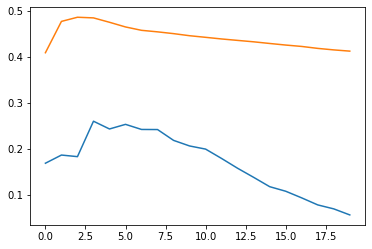

In [22]:
plt.plot(dca_suencoding_r2)
plt.plot(pca_suencoding_r2)

### Single unit variance/PI vs. loadings

In [27]:
from tqdm import tqdm
from neurosim.models.ssr import StateSpaceRealization as SSR
from dca.cov_util import calc_pi_from_data
from utils import apply_df_filters

In [28]:
with open('sabes_var_df.dat', 'rb') as f:
    var_df = pickle.load(f)

In [30]:
datpath = '/media/akumar/Secondary/data/sabes'
pi = {}
variance = {}
for i, data_file in tqdm(enumerate(data_files)):
    
    df = apply_df_filters(var_df, data_file=data_file, fold_idx=0)
    dat = load_sabes('%s/%s' % (datpath, data_file), **df.iloc[0]['loader_args'])
    
    # Do NOT Normalize
    #x = StandardScaler().fit_transform(np.squeeze(dat['spike_rates']))
    x = np.squeeze(dat['spike_rates'])
    pi[data_file] = {}
    pi[data_file]['dataT1'] = [calc_pi_from_data(x[:, j][:, np.newaxis], T=2)
                        for j in range(dat['spike_rates'].shape[-1])] 
    pi[data_file]['dataT3'] = [calc_pi_from_data(x[:, j][:, np.newaxis], T=6)
                        for j in range(dat['spike_rates'].shape[-1])]
    pi[data_file]['dataT5'] = [calc_pi_from_data(x[:, j][:, np.newaxis], T=10)
                        for j in range(dat['spike_rates'].shape[-1])]
    
    variance[data_file] = {}
    variance[data_file]['data'] = np.var(x, axis=0)
        
    A = df.iloc[0]['A']
#     W = scipy.linalg.solve_discrete_lyapunov(A, np.eye(A.shape[0]))
    variance[data_file]['model'] = np.diag(df.iloc[0]['W'])
    
    pi[data_file]['modelT1'] = []
    pi[data_file]['modelT3'] = []
    pi[data_file]['modelT5'] = []
    for j in range(A.shape[0]):
        C = np.zeros((1, A.shape[0]))
        C[0, j] = 1
        ssm = SSR(A, B=np.eye(A.shape[0]), C=C)
        pi[data_file]['modelT1'].append(ssm.pi(1))
        pi[data_file]['modelT3'].append(ssm.pi(3))
        pi[data_file]['modelT5'].append(ssm.pi(5))

28it [04:33,  9.76s/it]


In [31]:
dca_supi_r2 = np.zeros((dim_vals.size, 3, 2))
pca_supi_r2 = np.zeros((dim_vals.size, 3, 2))

for i, dim in enumerate(dim_vals):
    y_dca = []
    
    y_pca = []
    
    x1 = []
    x2 = []
    x3 = []
    x4 = []
    x5 = []
    x6 = []
    
    for data_file in data_files:
        y_dca.extend(result[data_file]['dca_loadings'][i, :])
        y_pca.extend(result[data_file]['pca_loadings'][i, :])
        
        x1.extend(pi[data_file]['dataT1'])
        x2.extend(pi[data_file]['dataT3'])
        x3.extend(pi[data_file]['dataT5'])

        x4.extend(pi[data_file]['modelT1'])
        x5.extend(pi[data_file]['modelT3'])
        x6.extend(pi[data_file]['modelT5'])

    dca_supi_r2[i, 0, 0] = scipy.stats.spearmanr(x1, y_dca)[0]
    dca_supi_r2[i, 1, 0] = scipy.stats.spearmanr(x2, y_dca)[0]
    dca_supi_r2[i, 2, 0] = scipy.stats.spearmanr(x3, y_dca)[0]
    
    dca_supi_r2[i, 0, 1] = scipy.stats.spearmanr(x4, y_dca)[0]
    dca_supi_r2[i, 1, 1] = scipy.stats.spearmanr(x5, y_dca)[0]
    dca_supi_r2[i, 2, 1] = scipy.stats.spearmanr(x6, y_dca)[0]
    
    pca_supi_r2[i, 0, 0] = scipy.stats.spearmanr(x1, y_pca)[0]
    pca_supi_r2[i, 1, 0] = scipy.stats.spearmanr(x2, y_pca)[0]
    pca_supi_r2[i, 2, 0] = scipy.stats.spearmanr(x3, y_pca)[0]
    
    pca_supi_r2[i, 0, 1] = scipy.stats.spearmanr(x4, y_pca)[0]
    pca_supi_r2[i, 1, 1] = scipy.stats.spearmanr(x5, y_pca)[0]
    pca_supi_r2[i, 2, 1] = scipy.stats.spearmanr(x6, y_pca)[0]    

In [36]:
dca_suvar_r2 = np.zeros((dim_vals.size, 2))
pca_suvar_r2 = np.zeros((dim_vals.size, 2))

for i, dim in enumerate(dim_vals):
    y_dca = []
    y_pca = []
    
    x1 = []
    x2 =[]
    
    for data_file in data_files:
        y_dca.extend(result[data_file]['dca_loadings'][i, :])
        y_pca.extend(result[data_file]['pca_loadings'][i, :])
        x1.extend(variance[data_file]['model'])
        x2.extend(variance[data_file]['data'])

    dca_suvar_r2[i, 0] = scipy.stats.spearmanr(x1, y_dca)[0]
    dca_suvar_r2[i, 1] = scipy.stats.spearmanr(x2, y_dca)[0]
    
    pca_suvar_r2[i, 0] = scipy.stats.spearmanr(x1, y_pca)[0]
    pca_suvar_r2[i, 1] = scipy.stats.spearmanr(x2, y_pca)[0]

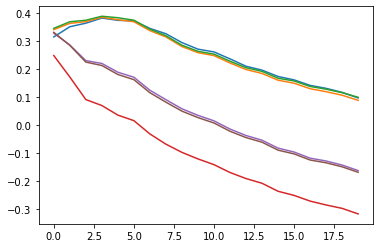

In [32]:
plt.plot(dca_supi_r2[:, :, 0])
plt.plot(dca_supi_r2[:, :, 1])

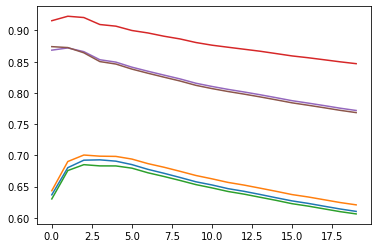

In [33]:
plt.plot(pca_supi_r2[:, :, 0])
plt.plot(pca_supi_r2[:, :, 1])

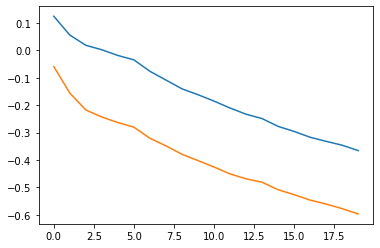

In [38]:
plt.plot(dca_suvar_r2[:, 0])
plt.plot(dca_suvar_r2[:, 1])

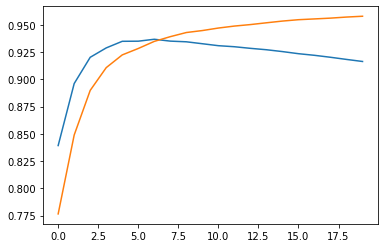

In [39]:
plt.plot(pca_suvar_r2[:, 0])
plt.plot(pca_suvar_r2[:, 1])

In [40]:
# Results needed for plot
r2_dict = {}
r2_dict['dca_decoding'] = dca_decoding_weightsr2
r2_dict['pca_decoding'] = pca_decoding_weightsr2
r2_dict['dca_encoding'] = dca_encoding_weightsr2
r2_dict['pca_encoding'] = pca_encoding_weightsr2
r2_dict['pca_supi_r'] = pca_supi_r2
r2_dict['pca_suvar_r'] = pca_suvar_r2
r2_dict['dca_supi_r'] = dca_supi_r2
r2_dict['dca_suvar_r'] = dca_suvar_r2

### Controllability 

In [ ]:
# Also need to calculate controllability metrics

In [ ]:
datpath = '/media/akumar/Secondary/data/sabes'
pi = {}
variance = {}
for i, data_file in tqdm(enumerate(data_files)):
    
    df = apply_df_filters(var_df, data_file=data_file, fold_idx=0)
    A = df.iloc[0]['A']
    
    # Single unit controllability
    for i in range(A.shape[0]):
        ssr = SSR(A=A.T, B=np.eye(A.shape[0]), C=np.eye(A.shape[0]))
    
    
        
    

In [41]:

ssr

NameError: name 'ssr' is not defined